In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("smoking/smoking.csv")

df.drop("ID", axis=1, inplace=True)

for col in ['gender', 'oral', 'tartar']:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop("smoking", axis=1).values
y = df["smoking"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [3]:
class SmokingClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SmokingClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = SmokingClassifier(X_train.shape[1])

In [4]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
train_losses = []
val_losses = []

for epoch in range(30):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_loader:
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1, Train Loss: 0.4998, Val Loss: 0.4654
Epoch 2, Train Loss: 0.4622, Val Loss: 0.4597
Epoch 3, Train Loss: 0.4568, Val Loss: 0.4571
Epoch 4, Train Loss: 0.4539, Val Loss: 0.4560
Epoch 5, Train Loss: 0.4522, Val Loss: 0.4567
Epoch 6, Train Loss: 0.4512, Val Loss: 0.4550
Epoch 7, Train Loss: 0.4497, Val Loss: 0.4566
Epoch 8, Train Loss: 0.4493, Val Loss: 0.4542
Epoch 9, Train Loss: 0.4483, Val Loss: 0.4545
Epoch 10, Train Loss: 0.4477, Val Loss: 0.4535
Epoch 11, Train Loss: 0.4463, Val Loss: 0.4553
Epoch 12, Train Loss: 0.4463, Val Loss: 0.4533
Epoch 13, Train Loss: 0.4456, Val Loss: 0.4546
Epoch 14, Train Loss: 0.4449, Val Loss: 0.4545
Epoch 15, Train Loss: 0.4441, Val Loss: 0.4549
Epoch 16, Train Loss: 0.4441, Val Loss: 0.4541
Epoch 17, Train Loss: 0.4432, Val Loss: 0.4546
Epoch 18, Train Loss: 0.4423, Val Loss: 0.4538
Epoch 19, Train Loss: 0.4421, Val Loss: 0.4553
Epoch 20, Train Loss: 0.4424, Val Loss: 0.4534
Epoch 21, Train Loss: 0.4410, Val Loss: 0.4561
Epoch 22, Train Loss: 

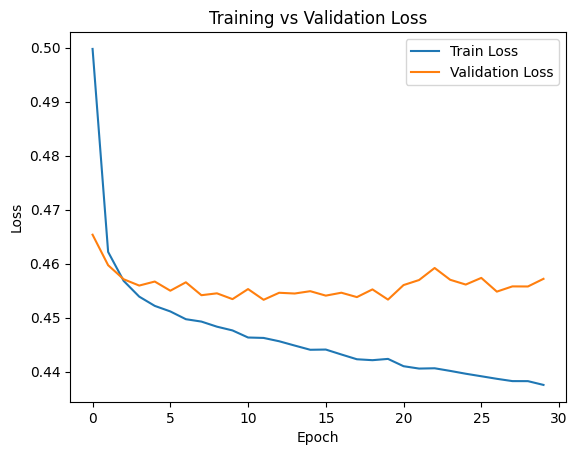

In [6]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [7]:
with torch.no_grad():
    predictions = model(X_test)
    predicted_classes = (predictions >= 0.5).float()
    accuracy = (predicted_classes == y_test).float().mean()
    print(f"Test Accuracy: {accuracy.item()*100:.2f}%")

Test Accuracy: 75.77%
